In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Preprocessed Data

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 3.9 MB/s 
     |████████████████████████████████| 895 kB 41.1 MB/s 
     |████████████████████████████████| 636 kB 45.0 MB/s 
     |████████████████████████████████| 3.3 MB 37.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
from transformers import GPT2LMHeadModel, GPT2Config, BertTokenizerFast
from transformers import AdamW, get_linear_schedule_with_warmup
import random
import os
import time
import datetime


In [ ]:
%cd /content/drive/MyDrive/KUBIG 2021-2 NLP

/content/drive/.shortcut-targets-by-id/17IUyurabTkMDpmeSDZHrFYpkmTE9MUoj/KUBIG 2021-2 NLP


In [ ]:
!ls

 FineTuning.ipynb		      'Generate Lyrics.ipynb'
 FineTuning_model_save.ipynb	       hip_fine_tuning.ipynb
'FineTuning_model_save.ipynb의 사본'   Indie-fine-tuning.ipynb
 full_hiphop.csv		      '가수 전곡 가사 크롤링.ipynb'
 full_hiphop_noenglish.csv	       KoGPT2-finetuning
 full_indie_noenglish.csv	       model_save


# 힙합, 인디에 따라서 주석 바꿔야 됨!

In [ ]:
# ind_df=pd.read_csv('full_indie_noenglish.csv',encoding='utf-8')
# ind_df.head()
hip_df=pd.read_csv('full_hiphop.csv',encoding='utf-8')
hip_df.head()


,Unnamed: 0,제목,가사
0,0,Ooh La La,<힙합>나쁜 일은 더이상은 겪고 싶지 않아 화난 채로 가사를 더 적고 싶진 않아 많...
1,1,Break Bread,<힙합>hook camo starr 우린 대식구 변한 거 없잖아 우리 attitud...
2,2,Automatic (Hi-Mix),<힙합>hilite in this bitch with the remix oh shi...
3,3,한라산 (Hi-Lite Sign) (Remix),<힙합>미래를 밝혀 주는 손싸인 니넨 뭣도 모르면 좆까 힙합을 논리로 푸는 병신들 ...
4,4,송석현 vs. 송석현,<힙합>송석현 그래서 니가 번다는 돈은 대체 언제 벌 건데 허리케인 그린 킹 별명들...


In [ ]:
# df=ind_df
df=hip_df

In [ ]:
# len(ind_df)
len(hip_df)

4593

In [ ]:
# lyrics_df=ind_df['가사']
lyrics_df=hip_df['가사']

In [ ]:
lyrics_df.head()

0    <힙합>나쁜 일은 더이상은 겪고 싶지 않아 화난 채로 가사를 더 적고 싶진 않아 많...
1    <힙합>hook camo starr 우린 대식구 변한 거 없잖아 우리 attitud...
2    <힙합>hilite in this bitch with the remix oh shi...
3    <힙합>미래를 밝혀 주는 손싸인 니넨 뭣도 모르면 좆까 힙합을 논리로 푸는 병신들 ...
4    <힙합>송석현 그래서 니가 번다는 돈은 대체 언제 벌 건데 허리케인 그린 킹 별명들...
Name: 가사, dtype: object

In [ ]:
# gens=["<인디>"] 
gens=["<힙합>"]

tokenizer_gpt3 = BertTokenizerFast.from_pretrained("kykim/gpt3-kor-small_based_on_gpt2", 
                                                   bos_token='<|startoftext|>', # begin of string [bos] token
                                                   eos_token='<|endoftext|>',  # end of string  [eos] token
                                                   pad_token='<|pad|>', # padding token
                                                   additional_special_tokens=gens)
 
tokenizer_gpt3.add_tokens("<br>")

Downloading:   0%|          | 0.00/344k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'BertTokenizer'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'BertTokenizerFast'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


1

In [ ]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer_gpt3.model_max_length)) # embedding size 체크
print("The beginning of sequence token {} token has the id {}".format(tokenizer_gpt3.convert_ids_to_tokens(tokenizer_gpt3.bos_token_id), tokenizer_gpt3.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer_gpt3.convert_ids_to_tokens(tokenizer_gpt3.eos_token_id), tokenizer_gpt3.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer_gpt3.convert_ids_to_tokens(tokenizer_gpt3.pad_token_id), tokenizer_gpt3.pad_token_id))

The max model length is 2048 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 42000
The end of sequence token <|endoftext|> has the id 42001
The padding token <|pad|> has the id 42002


In [ ]:
df.iloc[0]

Unnamed: 0                                                    0
제목                                                    Ooh La La
가사            <힙합>나쁜 일은 더이상은 겪고 싶지 않아 화난 채로 가사를 더 적고 싶진 않아 많...
Name: 0, dtype: object

In [ ]:
# 하나만 잘 돌아가는지 확인
ex=lyrics_df.iloc[0]

In [ ]:
outputs=tokenizer_gpt3.encode('<|startoftext|>'+ex+'<|endoftext|>', 
      truncation=True, max_length=768, padding="max_length")[1:]

In [ ]:
for i in outputs:
  print(tokenizer_gpt3.convert_ids_to_tokens(i))

<|startoftext|>
<힙합>
나쁜
일은
더이상
##은
겪고
싶지
않아
화
##난
채로
가사
##를
더
적고
싶
##진
않아
많은
사람들이
관람
##하는
우리
삶은
아름답
##기를
바래
약속
##하지
영원
##함을
n
##an
##a
n
##an
##a
o
##o
##h
##l
##al
##a
절대
망
##하지
않아
o
##o
##h
n
##an
##a
n
##an
##a
o
##o
##h
##l
##al
##a
쟤
##넨
반짝
##하고
가
y
##ea
##h
y
##ea
##h
y
##ay
##a
we
high
on
the
tr
##ack
im
##ma
fil
##l
up
the
bl
##ank
##s
al
##re
##ad
##y
go
##t
me
f
##uck
##ed
up
but
im
go
##ing
all
w
##ay
진짜
친
##굴
두
##네
나머지는
적대
커
##져
가는
머리
안에
채워
전부
품
##네
we
be
b
##all
##in
the
##y
ha
##te
to
se
##e
us
ro
##ll
##in
평가
##질
##하는
새끼
##들은
모를
거야
의미
해
##내고
나서야
쉬지
지금은
사치
##야
취침
할
건
오직
직진
wh
##en
b
##itch
##es
be
all
te
##st
##in
전부
여기
행복
##도
안정
##도
전부
여기
손
닿을
거리에
갖고
나니
결국
##에
남은
건
물질
##적인
사진
찍
##히지
new
fi
##t
이게
얼마
##짜
##린
##데
bo
##u
##j
##ee
내
life
##st
##yle
미쳐
굳이
따라
하다가
파
##산
##해
그지
나쁜
일은
더이상
##은
겪고
싶지
않아
화
##난
채로
가사
##를
더
적고
싶
##진
않아
많은
사람들이
관람
##하는
우리
삶은
아름답
##기를
바래
약속
##하지
영원
##함을
n
##an
##a
n
##an
##a
o
##o
##h
##l
##al
##a
절대
망
##하지
않아
o
##o
##h
n
##an
##a
n
##an
##a
o
##o
##h
#

# Torch Dataset Customizing

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel, GPT2Config
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list: # 노래 별로 encode후, tensor로 만들어서 배열에 넣음

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', 
                                        truncation=True, max_length=max_length, 
                                        padding="max_length") 

      self.input_ids.append(torch.tensor(encodings_dict['input_ids'][1:])) # cls 제거
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask'][1:])) # cls 제거
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

In [ ]:
len(lyrics_df)

4593

In [ ]:
# 전처리한 가사 리스트(lyrics_df)에 대해 파이토치 데이터셋 생성

dataset=GPT2Dataset(lyrics_df,tokenizer_gpt3,max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

4,133 training samples
  460 validation samples


In [ ]:
train_dataset

In [ ]:
# 토치 데이터 로더
batch_size = 2 # 서버에서 돌리면 다르게 설정해도 될듯
# GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. 
# This can be mitigated by accumulating the gradients but that is out of scope here.

# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Fine Tuning

In [ ]:
# # I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('kykim/gpt3-kor-small_based_on_gpt2', output_hidden_states=False)

# # instantiate the model
model = GPT2LMHeadModel.from_pretrained("kykim/gpt3-kor-small_based_on_gpt2")

Downloading:   0%|          | 0.00/526M [00:00<?, ?B/s]

In [ ]:
len(tokenizer_gpt3)

42005

In [ ]:
# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer_gpt3))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps 
#예로 사용한 데이터셋이 작아서 sample_every : 문장생성을  100 -> 20step 마다로 바꿔봤음!
sample_every = 100

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )
                

In [ ]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# 학습 진행되면서 learning_rate 바뀌면서 학습 빠르게 진행되도록 해줌.

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
for step, batch in enumerate(train_dataloader):
  print(step,len(batch),'batch[0] :',batch[0],'batch[1] :',batch[1])

Streaming output truncated to the last 5000 lines.
        [42000, 42003, 15367,  ..., 42002, 42002, 42002]]) batch[1] : tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
436 2 batch[0] : tensor([[42000, 42003,  5921,  ..., 42002, 42002, 42002],
        [42000, 42003, 30512,  ..., 42002, 42002, 42002]]) batch[1] : tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
437 2 batch[0] : tensor([[42000, 42003,  5667,  ..., 42002, 42002, 42002],
        [42000, 42003, 16622,  ..., 42002, 42002, 42002]]) batch[1] : tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
438 2 batch[0] : tensor([[42000, 42003, 17332,  ..., 42002, 42002, 42002],
        [42000, 42003,  2063,  ..., 42002, 42002, 42002]]) batch[1] : tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
439 2 batch[0] : tensor([[42000, 42003, 21548,  ..., 42002, 42002, 42002],
        [42000, 42003, 14803,  ..., 42002, 42002, 42002]]) batch[1] : tensor([[1, 1, 1,  ...,

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device) 

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device) # GPU 입력으로 사용될 tensor는 모두 to(device) 필요
        b_labels = batch[0].to(device) # ? 라벨? 마스크?
        b_masks = batch[1].to(device) # ? 

        model.zero_grad()        # 변화도(Gradient) 매개변수를 0으로 만들고

        outputs = model(  b_input_ids,  # loss를 출력하는지 확인.
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None 
                        )
 
        loss = outputs[0]  
        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0) # elapsed : 지난 시간 출력.
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval() # 학습 반영안되도록. generate 할때는? 잘 모르겠음.

            sample_outputs = model.generate( # 세대 토큰 넣어서 해봄, 눌러서 살펴보면 어떻게 쓰는지 나옴
                                    bos_token_id=random.randint(1,30000),  # The id of the beginning-of-sequence token. 랜덤한 단어로 시작하는 것.
                                    do_sample=True,# Whether or not to use sampling ; use greedy decoding   
                                    top_k=50, # The number of highest probability vocabulary  tokens to
                                    max_length = 200, # The maximum length of the sequence to be generated.
                                    top_p=0.95, # If set to float < 1, only the most probable tokens with probabilities that add up to top_p or higher are kept for generation.
                                    num_return_sequences=1, # The number of independently computed returned sequences for each element in the batch.
                                    repetition_penalty=2.0, 
                                
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer_gpt3.decode(sample_output, skip_special_tokens=True))) # id를 decode해서 문장으로 출력
            
            model.train() # train은 일정 sample_every step마다 하는듯.
        
        # 여긴 뭐 학습하는과정? 역전파 등등.

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():     # 학습 반영안되도록.

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append( # 바로 밑에서 쓰임. 정확도가 올라가는지 시각화할때 사용할듯
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   100  of  2,067. Loss: 1.824263334274292.   Elapsed: 0:01:36.
0: 진공성을 지닌다.


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   200  of  2,067. Loss: 2.224990129470825.   Elapsed: 0:03:12.
0: 뜰감처럼 흩어지고, 그 먼지들은 다시 뭉친다고 말할까 말까 할 때마다 머릿속엔 저 먼지가 마치 우리보다 더 높은 존재인 줄 알았습니다.


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   300  of  2,067. Loss: 2.476383924484253.   Elapsed: 0:04:50.
0: [unused815] oh ay yea hour i dont same girl but it gotta get another day im hard on the mothere baby thats what you love cannoon to be my face and tight me we lets realline like planet is lost see things 난 몰라 show roll for way no evening just differences in heart makin money up with u new rap kidshit caused out your hand carriers checktip from hippo this life of true album cliffure fuck at staidlys vintage back awaken hero so blind friendlesseye dark light sleeve bomb dead drop keep us aim not grant switch bucks 내 새끼들 조심해 brand


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   400  of  2,067. Loss: 3.2199461460113525.   Elapsed: 0:06:29.
0: 정리를 pills is the milk i was flex bang yo haze on my morning closed up and downs turned from hoya cherry jung with your face 내가 원하는대로 전부 해줄게 난 네가 보고픈 대로 널 만나도 되려 해 너를 찾아 헤메지마 내게 좋은 것만 주고 가지마 니가 원하면 어디든 다 갈 수 있어 ah what can sang somethings we different you could play all day mam to me please pray shine money forevers fuckin im not worries that late be in date comfort as call man like feel alessandro kim garden drank get out nobodiestly got us prove it aichaire gucci cards sign of our cream track rap boys poss


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   500  of  2,067. Loss: 2.0040180683135986.   Elapsed: 0:08:09.
0: ##젓 fface sites are you im on the world all night have to give me think i wanna blowin turn out with some lab shit from seoul san jack brown that it is my one yeah we got forever at home this triece 난 너를 원해 내가 원하는 것과 달라야 해 우리가 뭘로 살지 생각 해봤어 내 꿈에는 두 가지 있었지 많은 게 필요했지 꿈을 이루기 위해서 수많은 방법들을 다 써봤고 이 모든 행동들 모두 사랑으로 다가왔으니 그 다음 내게도 말해줘 나의 삶이 행복하면 넌 어떻게 될지 궁금해 오늘 밤은 너와 나에 대한 걱정들로 가득찬 하루이지 널 만난 것은 오늘이 마지막이야 더 이상은 네게서 연락이 오지 않길 바라는데 그게 아니라면 날 좀 달래 줘 그래 우리 둘만의 미래를 위해 노력했어 근데 니가 나를 보고 그냥 가만히 앉아있지 않을래 너는 왜 울고만 있지 미안해 니 인생이 아파


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   600  of  2,067. Loss: 1.9922987222671509.   Elapsed: 0:09:49.
0: ##사 내 모든 것을 걸었어 난 이제 다시 돌아가 다른 곳을 걸어 나흘 동안 쉬며 집에 가 쉬고 자고 반복된 하루의 끝에 내가 한 행동들의 결과는 과연 날 위해 무슨 짓을 했던 건지 궁금해질 때면 그냥 아무렇지 않게 지내다 시간이 흐르면 흐를수록 더 잘할 자신만 있다면 또 하고 싶은 것 하며 자야 해 어차피 시간은 흘러갈대로 지나가고 시간도 언젠가는 나를 위한 시간임을 알고 있는 게 현실이었기에 그저 웃을 뿐 아무 말이나 내뱉고 싶진 않았던 기억들은 가끔 후회가 되는 법이기에 그런 시간을 흘려본 순간은 아마도 오늘이 지나간 것처럼 기억이 계속 나는 중 누군가 내게 말한 말들이 기억에 남았었나 봐 혼자만의 추억에 남겨놓으려고 해도 여전히 아직까지 남아있는 건 분명해 나도 모르는 사이에 널 기억해낸 적이 있다는 것이 너무 다행이라는 생각이 들게 됐어 물론 이젠 잊었지만 그 후부턴 아직도 그대로 남아 있음을 알아버렸네 이 날을 마치게 된 것만 같아 사실 많은 얘기를 꺼내려 하지만 어떤 때였건 서로 똑같은 실수를 여러 번 했고 가끔은 그게 다 추억이 될


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   700  of  2,067. Loss: 1.8864824771881104.   Elapsed: 0:11:29.
0: 튠 gollo girl you on the air we gettin me up and now what run away to do for making its just chance i was like a bitches but youre said that follow im still really didnt knew yeah title put another new boss look at time is alone man in this front of my skystar faceboard multi pacifiture our branden shooter origina lets be seveentately cash money landon evers earthere ainotex music viba history cubelin bughins click some sign copped mindless day without good worring number1 damnagash u are verse2 asian credi


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   800  of  2,067. Loss: 2.375394344329834.   Elapsed: 0:13:09.
0: 붓 you know love yourself 넌 나랑 너무 달라 who the lie do i want 너넨 나만 필요해 난 나를 위해 이 감정을 담아둬 we ring already cant chees it me a long ya im gone with my side lets play no shit see her homies but thru bough maker in bed fuxxi motivate money that drinked hip to due just talkin on this mission from launch man if u aint get dicame somethings all day is depossible cash of us about breaks by ambition bitch paper ollaryn and anothers uptately or realization 나는 돈 때문에 내가 못됐지 안 돼 지금 할 수 있는 건 하나뿐야 니가 원하는 거랑 너는 뭐가 다를까 아마 두


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   900  of  2,067. Loss: 1.4740991592407227.   Elapsed: 0:14:48.
0: 유난 이 음악은 난 그 어떤 것도 안 멈춰 서 있어 너무 멀리 왔어 i dont give a flow but im on my bottom for you 내겐 오직 저 사람 하나뿐이야 내가 원하는 건 너라는 생각뿐인 것 같아 그래서 나는 다 잃었어 그게 나의 삶인지 잘 모르겠네 그저 뭐 어때 나도 너의 모든 걸 보여줄게 나야 넌 대체 몇 년이나 지났는지 알 수 있게 그냥 웃었네 우리 집만 빼고 전부다 말했어 진짜라면 됐지 어차피 그런 거 상관 없고 근데 지금 이런 일이 벌어졌을까 봐 걱정됐으니까 이젠 더 이상은 못 참겠어 날 믿어줄래 나를 지켜줘 매일 아침이면 널 보면 슬퍼져 눈 부신 채로 눈을 감아버렸잖아 어제도 그랬듯 너를 볼 때 마다 맘이 아파진단 생각이 자주 들었었는데 어제는 네가 내게 준 말을 듣고서 울어버렸었지 너도 이제는 이해해줬으면 해 정말 다행이고 또 한편으로 미안해지고 있네 왜 이제서야 이렇게 되었을지도 모르니깐 괜히 우울하지 않아 오늘까지 기다릴 순


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,000  of  2,067. Loss: 1.9304767847061157.   Elapsed: 0:16:27.
0: 뒙 i dont never give a fendi all of my flowin like west meridicated right noboss for nice man young day one tomorrow im how they says when u go backside with yuh ohening champagne baby so cool and wall only inched by love from jella bottoms put it stand up outta cuz that fake as fuck empertrack plent shooties at your money carry but real crazer brothers level take off more rounds heaver streeth eye dark simonfire 내 things is bullshit paid evereload alway pray if are problemise about good friens teach around not blind be


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,100  of  2,067. Loss: 1.9569684267044067.   Elapsed: 0:18:06.
0: 후드 right droppin i kill my way for it girl shawty stuck that bitches like rollie and cheese we the fools you aint gonna flexed a time but double get this cash with u can make money on to some texting fans of life in real sixteen yello head possessioning swervana low h1ghr up no problems attach anotherest imma be means thriap what popper star man muff lighters back all number 2 step by zone seould quarrage your bodys love from lamboration intro victim out line if always fine track one more feelings teluch us hopefind awaits mo


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,200  of  2,067. Loss: 1.1946022510528564.   Elapsed: 0:19:46.
0: ##할때는 너의 얼굴엔 까만색 눈 떠보면 눈이 부셔 너무 멀리 있어 난 우리 엄마 품속에서 널 찾고있어 너가 나의 주인인거처럼 날 믿어줘 내 눈은 빛나지 않을것같아 더 세게 안아줄래 내가 눈을 뜰땐 illionaire you in my cave 넌 나를 보고 있지만 imma better to the darkest for me on that lets get a lil than your own days dont play up all happen and goe why it makin life can should tell we feeling sex comed without right nough yeah 너는 절대 잊혀지지 않지 내게 soul을 채워줬어 사랑으로 가득 찼고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,300  of  2,067. Loss: 2.1279144287109375.   Elapsed: 0:21:24.
0: 스티커가 yeah we gonna dont believe with you happy ever like this boots in things a long lover im feeling on dark that girries head way what these sink not bitch of blood but i cant make your fragram or my breed real cerencers take off to drop it just chase momma rappin pillion 난 너를 위해 오늘도 달려왔어 넌 매일 내게로 와줘서 미안해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,400  of  2,067. Loss: 1.8649495840072632.   Elapsed: 0:23:02.
0: ##가지고 how so run with me what your fell of you like domino 난 또 도망을 가 왜 계속 같은 실수를 반복하지 우린 다시 한 번 더 가야 해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,500  of  2,067. Loss: 1.3616114854812622.   Elapsed: 0:24:38.
0: 넀 난 원해 니 음악만 해 너무 바빠 더는 못 참겠어 너 없이 살아도 괜찮아 내 목소리 들려 그냥 느껴봐 oh i be done sorry yea my brothers she ridin in the map but im stuck up baby now a got on and get this trynna pop like me plz follow us what u could love you forever too haters take off time with that handle feedbacking peoples catch side not gathered all we can never keep put it away at your dripper is real muchable or hirricheous clouds hook throughnession wanna check back tell man comes both even straights over dawg lose


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,600  of  2,067. Loss: 2.5878520011901855.   Elapsed: 0:26:17.
0: ##청정 rainbow pull up all of my heart 내 발밑에 dunk i want this hobby is fuck with me too manyed so let you just goin besider im a flush dope hit on the big things ouh 이 새끼들은 다 부랑자 그래 이게 무슨 소리야 난 걍 개소리하지 이제 다들 알잖아 ucc no cap till see and close city givenciaga said as it stoles for deepfare that masked her earphone whats wrecking hala lost attant shine ladiers are yall katrom chase back fiend mulamond reasons like abnorith passion but anti producery family plan in love your never know ever spotled from mothere


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,700  of  2,067. Loss: 2.8811254501342773.   Elapsed: 0:27:56.
0: ##틥 난 네가 싫었었나봐 다 알고도 나는 너에게 더 가까이 와 있어 내게 너를 보여줘 니 손을 잡고서 말을 걸었네 그 순간은 널 향한 나의 온기가 느껴졌나 봐 지금 넌 내가 좋데 아마도 니가 좋았네 아니였다면 또 이렇게 사랑할 수 있나 정말 모르겠는 너의 말엔 답 못해 아마 나였을 거야 이 느낌이 너무나 무서웠잖아 이제 이런 감정들이 참아줄게 다시 안아준 건 아직 없지만 그래도 이미 지나간걸 알면서도 여전히 남아있는 듯해 미안해요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,800  of  2,067. Loss: 1.8702269792556763.   Elapsed: 0:29:34.
0: [unused1037] i just do this way about you its goin someone im really looking for that in them ever now whats up to get money take out yo things and bill my number 1 holes 2 bentlence says hit on with makes brand new menu necks is stupid littelies rich해 마치 post phasic a good heart facetlined paul cage trianggar shock coz에 누워 내 목에 걸린 vacain은 금고 나의 지폐는 다 깨버려 이 돈은 저금할 때 됐어 난 절대 못 뺏을게 cheese를 녹여내 새로운 곡이 곧 나와 lets drive oh rolex boom damns we aima knew your fuck all day u lab game


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,900  of  2,067. Loss: 3.1444454193115234.   Elapsed: 0:31:13.
0: [unused972] baby you my love everydays i want me girl but 내 마음은 몰라 니 맘 알어 지금 나의 마음 알아 난 아직 너의 마음이 뭔지를 몰라서 널 보고 있는 건 너무 창피한 거지만 그래도 너를 사랑하는 게 나다운 거라면 넌 네 맘이 어떤지는 모르지만 모른단 말이 아니야 나는 아직도 모르겠지 너와 함께라면 yeah 내가 정말 행복해 질래 나도 그런 걸 수도 있지 너도 내게 원하는 거잖아 왜 이렇게 된 건지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,000  of  2,067. Loss: 1.6133341789245605.   Elapsed: 0:32:50.
0: 늪 uh 이 길은 언제나 아름답어 i gotta do it right now yea 내 두 볼에 키스해도 너무 좋아 네가 널 안고 있다면 내가 먼저 날 데려가겠어 ooah 너를 보고 싶어 오늘 밤은 너에게 잠길게 아무에게도 나를 바라지 않는 너는 나뿐이ay ayou are todays all day you livin at me when weekend give up ever eyes just walking taka diamond cash shit on the lade huh makes money check some piece of my bonz and that fuck em drunch asian 난 너의 마음을 알지 그래 그 사실을 나는 알고 있어 내게 말해 줘 지금 당장이야 아님 아니 어쩌면 그럴 수도 있잖아 넌 나의 전화를 받아도 되냐는 질문에는 대답 못해 baby 그냥 물어봐 줄 수가 없구나 니가 필요해 네 맘이 왜 그리 급하다고 생각하냐면 나도 마찬가지야 사랑한다면 그게

  Average training loss: 2.60
  Training epoch took: 0:33:57

Running Validation...
  Validation Loss: 2.41
  Validation took: 0:01:11

======== Epoch 2 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   100  of  2,067. Loss: 3.0652425289154053.   Elapsed: 0:01:36.
0: 턎 oh yea mothafuckin me so what you gon punch babys but i cant get it tell huah nobody know might loud all the close and take that boys wit your dick be imma dont change to hasha drop here for like shawater ring a damage giribon in cali hood just pausee u minds if vacay once ok nice satellion man is cool slimpietang my life stand or alive leader sip as fukuristic time flows out of day were not feel thotties seemed ma favorite peerle playful heavens at highway verse 1 난 이 도시를 떠나고파 다시 말해 지금에 내 모습을 잃어버리면 어때 그건 내가


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   200  of  2,067. Loss: 2.6922757625579834.   Elapsed: 0:03:15.
0: 픱 이 곡에서 나오는 가사는 꽤 아름다웠었는데 im woo you cant make me a shot kissin about my grinds in depression going to get out peace all i need is legendary bro it real love for no club yeah girl that we beat and didnt tryna cares ever time at yoursell feel like the other long rich this are not previously but alone anothers untire somethings around her hash talk as fuck with saint laurenciaga veni danchamon bitches hugh 내 음악이 네 몸에 묻은 걸 핥아 넌 왜 항상 날 무시해 널 그냥 놔줘 제발


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   300  of  2,067. Loss: 2.850466728210449.   Elapsed: 0:04:54.
0: ##르기 verse 1 let it go yello rockstar insane we on asap oh shit is tokyop signed the mission im give u some fuckin problems can tell em feel no more paper till i want my back and double piece broken cross racket like a pop what ever mothaful you coming throughe message about how could true or dive if your real causes hatin babi that flow with her hand bless up vacay all night awake hundreview of time alreadies aint forgeted pleaming cuz anothers eartisian guccibition studio가 차려놓고 내 style대로 사는 인생 but boom outlesvation


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   400  of  2,067. Loss: 2.234044313430786.   Elapsed: 0:06:33.
0: 심플한 vibes we liv in tonight wavy child with all numbers up my beast yeah it done and trust you so blaze i making a lot of feelings bitch on this movie 난 돈만 버는 직업 근데 다 잘 안되지 너무 많은 일이 벌어져 uha what im goin bout me 너에게 필요한 건 항상 돈이 아닌 거 같아서 신경 안 써 야망이 넘치게 살고 싶지 않은 꿈에 사는 삶 더 좋은 걸 원해 내 삶은 달라 나답게 살긴 무슨데 shout outta the game 나는 돈을 조금 벌 수 있단 생각에 살아 움직여야 되는 것 같아 그런 생각이 계속 맴돌아 니 생각은 날 보는 거지 사실 넌 나를 못 본 채 싫어하고 싶어 그래서 매일 밤을 새도 또 다른 꿈을 꾸고 있지 그래그래 이제 일어나면 돼 이젠 내가 뭘 할지 얘기하지 말고 그냥 편하게 잠이나 자 그럼 일어날까 뭐 어차피 우린 원래 있던


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   500  of  2,067. Loss: 1.85393488407135.   Elapsed: 0:08:12.
0: [unused865] now we should really want it rapping like that fukhuse you too ill makes me in love and im grindin with this ya homied out of my eyes bout a thank god beci on the same road pillem up lately lovas just keep play u never know 난 balenciaga guccible kiediers motherfucker city dont give all sign nidae or passion is not fasterles so deal but for summertime are comen by enjm about your brothel muff take evacay pour over ocean couter at least asian trend cant stop hit ursery what camps periods time close off works around


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   600  of  2,067. Loss: 2.547473430633545.   Elapsed: 0:09:51.
0: ##량은 so i wanna live this is my life say got it again im here baby 니가 내게 날 더 세게 안아줘 넌 난 널 원해 내가 너 없이는 못 버티겠어 이제 다 됐고 잘자고 내일엔 편히 쉬어 우린 너무 많이 닮아있어 이젠 너도 가끔은 잊고 싶을정도로 말이야 우리 사이도 점점 가까워지고 너는 매일 나를 따라다니고 있어 나는 사랑하지 않을 사람이란 생각을 하게 되는데 이제는 너를 위해 다시 태어났으니까 왜 내 맘을 모르겠지 너의 마음 그게 바로 나야 가끔 이런 생각이 들게끔 만들어 근데 어쩌라고 미안해 나도 알아 요즘 네가 얼마나 괴로워하는지 그런 말을 할 수 있는게 미안한데 이렇게 살아보니까 이 기분 알 것 같은데 어때 이게 진짜 좋은 거니는 아니지만 괜찮아 ever follow me good morning when the heart all day we dont give a tastem shit 모든 게 좋아져 아무 때나 막 쓸 수가 있지 뭐 그래 사실 별 생각 하지 않는 것도 좋지만 그래도 혹시 몰라 니 마음이


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   700  of  2,067. Loss: 2.2693047523498535.   Elapsed: 0:11:30.
0: 쯰 its been broke on the track i dont know what my money got me and lovin song like uwhere that you say through this are a new rushed up we get around for ladies stylist everlasting to seoull bad way with her back in one night nobodys borrowers cance feel us an old dangeration aids happens hear your eye cross im such art fresh yea lets makake chasings telly drink deal givenciate picture kinda graffities all day always courigh ur homieto moms love is smile but not muchable shows bless em just turnta keep cash outton at paus


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   800  of  2,067. Loss: 3.065898895263672.   Elapsed: 0:13:09.
0: 비하면 난 계속해 말해 내 말 이제 다 알아듣도록 해둬 내가 잘 알잖아 내게도 이젠 더 이상 날 찾지 말아 줘 제발 부디 i look what you want to me thats the one we are all good night yeah im gonna shine without girl in this club but realized everydate and if it rain now not trust fuckin lil hoes dont feeling judgivity on my minds take a bitche sexually let your blessle sometimick our friend catched actor studio bout us up miss u facebooties officer majore passion of worse day at home place dangerous crazys astradio abufficial pure scare lab smashers beats ar


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   900  of  2,067. Loss: 1.7052481174468994.   Elapsed: 0:14:48.
0: 보상 girls me and you love i dont say big my thing who is hella im todays withem pusdum up the lottom now once that bout your back wit from a changgook launched it cash this money all day been timelesue ye 내 우린 매일 해 뜰 때까지 일해 이제 곧 떠날거야 니 침대 위에서 내일도 똑같으면 싶어 oh motherfuckers followin nightmare someone u aily cool comes about short home like friday we everway in japan kawaii vacation sign of buffeties gozard but not realize verse 1은 다 뺐지 lets get more homin dignoiste se kegativity turn alive


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,000  of  2,067. Loss: 1.903538465499878.   Elapsed: 0:16:27.
0: ##소다 verse 1 i been want to me for love girl yeah im already know 난 지금 너한테 전화해 baby bottom now 내가 누군데 왜 이래 turned on my back 내 허리에 look at the light lets get it stack like hoes in a pocket realize dumin ma fuck about your plan doing drive gonne see you finder shake up all this movements so high and closed u said evil enough cuz we aint sick by that call one time who are urtivate with us rollie puspies combata man if you can telly not true fresh ride anotherectual keep choppa free peace never hate but things action of jewelry guys fe


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,100  of  2,067. Loss: 1.3579972982406616.   Elapsed: 0:18:07.
0: 조금만 yeah im goin running girl i wont see you bad and they let me sick another one ovan beat u know whats up for your mind 난 매일 반복해 나를 알아 broken througie but it is my judge of life thats only feel a love fuck asap shawts all day back eversion paid chance to call makes this time from us song her bout larry store nike louis vans cocaine well in livin dressed now get out hour turn around renderent cup starve comet problems hase nottime dig fighter deal without muchdifford possible money doubles hipster killas pizza jo


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,200  of  2,067. Loss: 3.013042449951172.   Elapsed: 0:19:46.
0: ##벏 i got a short dollar when im trynna tell me think about in the battle and that dreams for yo murders like deboragotha said but fuck you callin sometimid right now just ever walk to flex huh lose anothers here if u feeling it fair with your name is past were all makes place of us have more check around my life from porm headway comed out at this peoples are worring ouress uncently reason mobile sign by roulda eschati be cool dance spicilianaicks will smart hope up late money lets crush back on boxage new alcohandary gold


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,300  of  2,067. Loss: 2.227182626724243.   Elapsed: 0:21:25.
0: 톔 내겐 그냥 친구야 나를 좀 봐 니들 인생은 다 비슷해 근데 난 너무 달라 너가 뭐라 해도 너는 못 해 넌 네게도 나 같은 놈이 하나 없어 걘 내게 연락도 안 받고 야 그래 니가 싫다면 너도 널 받아줘 내가 먼저 날 믿어 이 노래 제목에 네가 없다더라 왜 대체 어디서 나온 건데 you know there is like why im popnin to be someone i gotta save me dont forgeted yeah get out with no long time wayside never all night and madalia come on cash in a track that shit having run awake up ever heard just mistry thang sippie studio we aim fuck it from money man girly mothafficoi bitches are da tasted but my lifestyle far asian flex


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,400  of  2,067. Loss: 1.7117550373077393.   Elapsed: 0:23:04.
0: 보통 나는 나락인데 잘난 척 하는 거 아냐 날 따라 해줘 내가 널 사랑 안 할 땐 내 인생에 나쁜 추억이 될 것 같지 난 이 지옥 같은 세상에서 빛나네 그 누구도 나의 편이 아니잖아 네가 나를 미워해도 너가 내게 뭐를 바라도 절대 절대로 포기하지 말아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,500  of  2,067. Loss: 2.3935625553131104.   Elapsed: 0:24:41.
0: ##어졌 너네는 지금 어디에 있어 오늘밤만 나랑 있으면 좋겠지 매일 밤 혼자인 집 안에서 널 생각하며 살겠거니와 더는 너를 바라 볼 필요가 없으니 이제 난 네가 좋아 할 줄 알았던 너의 모습보다 훨씬 나 자신을 사랑할 것 같아 내 마음속의 불을 끄며 잠들고 싶네 나의 곁에서 우리 둘이 있는 그날이 오면 넌 나를 생각해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,600  of  2,067. Loss: 2.61076283454895.   Elapsed: 0:26:18.
0: ##쎼 uh yea shit 난 매일이 싫어 im fuckin too laughed girl i came on my fashion and some testing it for this brand new waves 내 친구야 넌 날 이해 할 수 있을 거야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,700  of  2,067. Loss: 2.3854997158050537.   Elapsed: 0:27:54.
0: 쭉쭉 my soul girls in the darkest imma be your one of you and shine we gon brand new york time to seoull swagt up with a jumpy same people truck 난 잘 봐 너는 알아 i alread it again think about me but 내 옆에 있는 애들의 표정을 알어 네게 말하네 너가 날 더 빛나게 하는 건 넌지시 그런 널 보고 있으면 나도 모르게 미소를 짓네 나는 나를 몰라 그래 어떻게 이렇게 나 이러나 싶은 거야 니가 왜 이래 너의 손을 잡고서 떠나간 걸까 내가 니 맘에도 없는 거를 들고 와서 아무 말도 하지 말고 가줬으면 해 하지만 이 기분을 알기에 네가 아닌 척할래 uh whenever for this main distance that lets hearing all good love till not evitted on piece isnt like her pandemberry causes chee


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,800  of  2,067. Loss: 3.8180837631225586.   Elapsed: 0:29:33.
0: 87 intro in the game listen a view of wonderful see its ridin field and i cant stop all obstructions that some level now imma do anyone go get ma bite you fuck with dudes 난 혼자인 적이 많지 but 내 친구가 생겼어 걔가 내게 말했어 나는 힙합보단 랩을 더 잘해 근데 왜 나만 힘든 건지 모르겠네 날 봐봐 네가 알던 내가 이제 너흴 보면 되냐고 물어보면 그냥 이렇게 대답하겠지 뭐 어때 나도 같이 살고 있는 건 아니기에 너도 마찬가지야 나랑 같은 삶을 살기로 했다면 오늘 밤은 아마도 나였겠지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,900  of  2,067. Loss: 2.3529133796691895.   Elapsed: 0:31:12.
0: [unused208] verse1 shit dont talk about me im just ballin at the plane when i need my people money things that boo says not a gang but stay better no worries 난 다 보여줬지 내가 받은건 이율배반 너무 뻔해 돈이 없으면 너도 못봐 그게 왜 문제야 이건 우리 엄마 자랑이야 이게 뭐 대단한거냐 또 다시 말해 니네는 날 모르기에 나보고 어쩌라고 oh 너네 얘기 진짜 싫어 나는 거짓말 안쳐 근데 내앞에선 약 올려도 넌 무시받아 걔넨 나를 몰라도 해 절대 신경안써 그래도 가끔 말곤 몰라 니가 뭔데 그래 너는 그걸 알겠지 우린 정말 서로를 이해 못하는게 솔직한거고 그건 그냥 장난이고 걘 나한테는 존잰 없는 놈이라 하지 어떤 말을해도 입아퍼 뭘 알아 걍 농담이지 그러니 내게 물어 제발 미안하다면서 u know if you retired 네가 잘되면 나도 행복해질


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,000  of  2,067. Loss: 3.9336016178131104.   Elapsed: 0:32:52.
0: 다용도 내 첫 앨범에 니가 없을 때 난 많이 서운해 내가 너무 미안해 그래서 너를 이해하려 애쓰네 네 말이 맞아 너 때문에 나 같은 날 보고도 못 들은 척하던 니 생각이 다시 떠올라 근데 그 시간 동안 넌 어땠어 왜 그리 화를 내는 거야 혹시 널 위해 쓴 가사가 이런 게 아닌데 그런 거 아니고 아무 말도 아냐 아마 그럴 수도 있겠지 나의 맘속 어딘가에서 울려 퍼지는 소리가 들려와 너의 옆에 있을 수 있게 해줘 oh i dont know me to be my soul they aill making what you realler not just want anothernmones with your girl and bout a funnidity lovely all about lets go yea she says imma alive but now mand still like that loner west kind of summertime comes in this world right home 우린 늘 여기서 살아있어 사랑하지만 서로 힘들잖아

  Average training loss: 2.32
  Training epoch took: 0:34:00

Running Validation...
  Validation Loss: 2.36
  Validation took: 0:01:11

======== Epoch 3 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   100  of  2,067. Loss: 1.7812737226486206.   Elapsed: 0:01:37.
0: 생수 i dont lie to say with my race when you better see u a grade babies and im fuckin relations in this picture goes the started from anesthetic low currenchly so high asian thing it havas ever leave that just suffers out of clouds but nonessed up girad bouggage our dreams on stage for sight all nice time we get yoursellance brand new testings can never feel shine wit me away if free minutember fing dawn empensive rolex heartbrush makeshow buonistics spend mothephone kill houseep tank one flexor attachevisional paggless proo


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   200  of  2,067. Loss: 1.7209947109222412.   Elapsed: 0:03:17.
0: 싦 i got this dough the trap started from my way to looking at that laters now it like sophodia and beaches in cage h1ghr gang while im still right or drownin haze for me legendary yea well make a new talent without pasta but you aive balanceed damn above if u can tell your handle on us anythings reallies hop never hear around just keep her bro decision vidi east asian thriftest shit buffet timelesquem roundstape boys getting slowly cheese nakedice segaratory dipper knocken off feel spectrumbloomine twisters


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   300  of  2,067. Loss: 2.3098762035369873.   Elapsed: 0:04:56.
0: 세미 verse 1 oh yea i been trapping my mind get in all the planes girl 난 모든 사람들이 날 사랑해 하지만 내 진심은 가짜 나를 좋아해 너의 마음을 절대 뺏을 수는 없기에 baby love you u why dont know 나도 너를 정말 사랑하고 있어 나는 널 위해 기도해 네 마음 깊은 곳에다 이 어둠 속에서 나와 함께 헤엄쳐줘 니 얼굴에다가 뽀뽀를 해 줘 나의 품에서 니가 안 느껴져 불안해서 넌 왜 항상 내게만 그렇게 물어 너가 원하는 게 뭔지 알아 도대체 알 수 없다는 거 아는데 wait to hit that me and now im leave at somethin but youre just looked her feels about lavida viviano 우린 너무 달라 그 동안 내가 많이 변했나 봐 다른 사람 같은 기분 너도 알고 있겠지만 착각하지 마 오늘 밤도 나뿐이면 충분하니까 we never bullshine like a bomb


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   400  of  2,067. Loss: 2.486114501953125.   Elapsed: 0:06:36.
0: ##쩹 난 너무 많이 자랐어 근데 내 눈엔 넌 여전히 깡패야 내가 널 갖고 싶진 않아 너의 말론 너가 날 가지고 싶어하지 않는다는 걸 너도 잘 알겠지 다 똑같은 얘기 같아 보여도 이런 게 있는 줄 알았을 거야 그래 우린 이미 서로에게 조금씩 멀어지고 있어 지금 같은 사이가 계속될 때 우리 사이 얼마나 원했겠니 그 정도라면 모든 건 사랑이란 이름으로 남아 있을 거니까 oh i said you are alone 너는 내게 사랑을 주지않았고 단지 사랑으로 나에게 다가왔기에 그저 행복하기만만 했네 yea let me go all night we know 왜 네가 없는 곳에서 잠을 자게 됐는지는 말해줘 아직 기억나 한 가지 예를 들면 니 남자친구가 너를 보러갔을 땐 그날 밤 비가와서 밖에 나가질 못했었구 대신 거울 속에서 나의 모습을 상상하곤 했지 나도 비슷한 사람이라서 매일 빗소리를 들었었지 이젠 아냐 그럴수도 없지 이제 네 맘까지 완전히 알게 해줬지 이제는 아니야 하지만 니가 없었다면 절대 몰랐었을거야 사실 나는 이


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   500  of  2,067. Loss: 3.515591621398926.   Elapsed: 0:08:16.
0: ##욨 너가 가진 게 뭔지 알겠니 넌 모르겠어 내가 갖고 있는 걸 왜 물어 니가 말한 걔넨 대체 뭐가 좋은지 몰라서 난 아직 더 벌어야겠어 날 알아챘던 건 오직 너의 얘기뿐인 널 믿지 말기로 해 나는 아냐 안 믿을게 네가 내게 보낸 문자 그 후로 몇 달을 지새웠지 매일 전화해서 하는 거마다 나보고 다했녜 i dont give a fuckin dream ya 네 인생은 너무 단순해 지금 내겐 전부 의미가 없는 거야 이제 와서 뭐라 하기는 싫어 솔직히 말해 이런 바보 같아 너는 나한테도 자랑스러워서 나도 너도 잘 아는데 이렇게 쉽게 잊혀질 거라니까 니 진심을 알게 해줘서 고마워 이제는 제발 나를 의심하지 말아줘 근데 사실은 그게 나쁜 거라고 생각하곤 했어 사실 사랑한다고 말하면서 자꾸 남과 섞이고 싸우다 보니까 사랑이란 단어가 어색해졌나 봐 그래 맞아 사랑은 정말 아름다워 아름다운 만큼 잃어야 할 것은 많더라고 그냥 예쁜 사람이 되기로 한거냐고 원래 그렇게 생긴 걸까 하지만 이건 거짓말이 아니었


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   600  of  2,067. Loss: 2.4759278297424316.   Elapsed: 0:09:56.
0: ##ㅃ baby you should be sleepin and bless your mama i count down in this motherfuckers too many friends on me like c jazzle feel the same time girl that im alive what it is wava loved 매일 밤 날 따라 yeah sexually everyboujane day off u are my side let up ifeverever 우린 어제와 같은 기분이야 look at week our dance without all night back of soul boombies get outta need around none swings heading from deepflow for remode brink eyes lavitate can drown ridge comes go anothernity triples have a talk abook focus chasian pluggable 난


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   700  of  2,067. Loss: 1.805189847946167.   Elapsed: 0:11:36.
0: 숔 yeah i need that whole girl 내 모든 건 다 all these fashion 너네 여자도 니 옷 속에다 숨겨 난 이제 너무 바빠 we camera asap 나는 지금 밖에 있어 우리 둘을 데리고 이 곳을 떠나가자 비행기 시간이 되면 bae you wasnt know how it like this even if im doing bout me better than a long time 너의 두 눈엔 visco fuckin sexy movies are your name 우린 어디야 어디를 가던 넌 어디로 가 너도 나의 옆자리에 앉아서 눈을 맞추길 바래 plz for my old life 너는 여기 저기에 있지만 오늘은 내가 좀 늦지 feel fine too late anothers can still makes ur heart but always only drown with money and goose just get em right no more 돈 벌어야만 해 더 이상 나를 부를 필요없어 이젠 어딜가든 널


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   800  of  2,067. Loss: 1.1961767673492432.   Elapsed: 0:13:16.
0: 큔 내 방에 암막 커튼 쳐 놓은 너랑 함께 yeah i cant stop ride off the room 거울 속에 네 모습이 선명해 oo 너의 눈은 아직도 투명 그 눈빛을 본 순간 난 너무 흥분해서 계속 눈을 뗄 수 없어 지금 이 순간에도 너는 나를 향한 시선이 쭉 이어져 있어 잠깐의 실수가 널 웃게 만들었지 그래 이런 일이 우리 서로 처음 시작부터 처음부터 모든 것을 바꿨다는 듯이 오늘 밤만 살고 싶어 나는 다시 돌아가고파 제발 좀 더 가까이 오려고 일부러 내가 도망쳐 버린 것처럼 넌 나의 방문을 닫고서 나가줘 저 멀리 있는 너를 보면 정말 미치겠어 다신 볼 수가 없는 모습으로 보여 미안하고마 나도 가끔 이러쿵저러래 네가 자꾸 생각나 괜히 울어 나 같은 놈들 때문에 항상 집중하게 되네 다른 여자애한테도 그런 말을 할 때면 니 생각만 나고 말야 매일 내게 이렇게 또 전화 오면 어떡하냐 그냥 모른 척 하고 싶어도 어떻게 해볼 도리도 없어서 어쩔 때는 날 잡고서는 한 발짝 물러나도 안 된다고 끝까지 고집불


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   900  of  2,067. Loss: 2.0724546909332275.   Elapsed: 0:14:56.
0: 보여드리 내 기분은 ready to you baby turn it rain girls dont stop hop like now im lonely i gotta flex with me nextime beer that love all of soju but there is hard about us youre my type if u made this shit and ya comes trip drink a minutor hello blind out at fiction rose once agonade signed up in peace lets get high forevers we want her claim funds one thing even keep along boughter suckup just telleve fast night mama callin works pleaten over money cannondisclear dingarfuckaband chillings brothel off our paper coast notice 1 said 2


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,000  of  2,067. Loss: 2.5104830265045166.   Elapsed: 0:16:35.
0: ##뫠 너 없이 난 이제 떠나게 돼서 미안해 나 아직도 널 원하고 있어 그녈 위해 준비한다면서 왜 내가 날 두고 가지도 않겠어 다시 나를 놔 줘 제발 안 놓겠어 내 맘이 너를 향한 것만 같대도 네 말이 그냥 다 맞아 줄거란 생각이 들었지만 아무 말도 할 수가 없었지 너무 외로웠었지 또 너는 내게 잘해 주고 있냐는 말마저 나는 무모하게 굴었어 네가 만약 이랬으면은 그때 좀 더 사랑할 수 있었겠니 다른 남자들에 비해 솔직히 잘 모르겠네 이게 바로 너의 마음뿐이야 근데 사랑은 끝이 없는걸 알고 있었는데 그런 감정들 속에서 이 사랑이라는 건 어쩔수가 없다는 게 문제야 어쩌면 이대로 사라질 수만 있다면 그렇게 될 수도 있는 걸까 이런 일이 반복되다 보면 너도 변해 있겠잖아 그래서 헤어질수도 있단 걸 알면서도 우리 둘만의 이야기라서 그리 아쉬워하지도 않았었던 것처럼 정말 아무것도 아니야 서로가 서로를 위해서라면 그건 나의 선택이 아니지 그저 나만이 아닌 모든 사람들과 함께 걸어가면 되니까 i dont mind to be anything


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,100  of  2,067. Loss: 2.5034542083740234.   Elapsed: 0:18:14.
0: 둿 난 원해 오직 지금 이 순간에 내가 하고 싶은 걸 할게 내 맘을 다 줄 테니 네 곁에 있어줄래 너란 여자가 날 위해 해줄 것 같아 나도 너를 찾고 있지만 네가 떠나고 나면 후회 돼 you aint no matter why it is my one were in that night i said youre just been thinkin about and give a shit for angels down to go getting all day this way im finessing like suda raingamo turn on em yeah boi ever brokey old hard lets loose up awake u misery with cash darkly montana picked over of the climb so manux chicago quiete seoull laughera cuz alone smart keep as trade sign motha fendencies bag


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,200  of  2,067. Loss: 1.8352546691894531.   Elapsed: 0:19:53.
0: 늅 because i really want that shit we stackin its all day and night now cali on my diamond chain jeans dripping hold up imma brown mask for pillies in the bottom yo ah ouis givenche smoked like when he sick of money think dumb but not u alwayse feel somethings aint never gonna find your grade is evil you fuck with me baby sad to have patient guys get her prada의 face ask em blahome lets do sure man trust angel robbie combo rubber jovans keep mofangem kind ot lords player spring seoull place talk lane cr


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,300  of  2,067. Loss: 2.1985278129577637.   Elapsed: 0:21:32.
0: ##돴 난 너무 쉽게 도망치네 i hate my name is always in love where the way 나는 나를 알아가고 있지 내가 가는 길을 너는 전혀 모르지 이 바닥을 헤집고 다녀 다 잃어버렸어 너를 못 잊었어 날 다시 기억하지도 못해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,400  of  2,067. Loss: 2.61448335647583.   Elapsed: 0:23:09.
0: 댷 이 판에 또 낄끼빠빠진 애들은 뒤로 자거나 아님 죽어라 싸운 다음 날부터 시작되어 내 몸 속에 들어온 거 죄다 쏴버려 패잔병들의 무리 그래 네 눈엔 이게 다 무슨 상관이야 내가 바로 밑바닥의 애들 중 하나 너넨 말했잖아 이제 시작이라고 여기 누가 뭐라던 상관 말아 임마 그냥 앞으로 가라고 난 말해봐 근데 넌 왜 몰라 대체 어디에 사는지 뭘 말하는지도 모르면서 뭔만함 도망가자 그럼 나는 네가 원한 그 자리에 있지 못 하겠어 더 멀리 가자 결국 나한텐 없어 왜냐면은 다른게 필요해 sometim that i dont wanna call my plan and grab they aight a bitches for readined now we gonna be alrive but never take it right nothin to this shit u difference all loses you oopgies can just popping hu


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,500  of  2,067. Loss: 2.2335164546966553.   Elapsed: 0:24:48.
0: ##쓷 rap stars in this artist vision gang bitches on hip hop studio 난 더 나은 것을 원해 또 여전히 넌 날 몰라봐 근데 내 눈에 비친 미래는 so im thinking about you number of old truth i dont want my facebook is fuckin asian 내가 너의 팬들 who u be like that 나의 팬들은 대부분 너무 외로워 보여 네 앨범은 몇 장씩 팔린 반면 그 중에서 내게 제일 와닿는건 다름아닌 음악이였지 이 음악들의 공통점은 우리 팀에 대해서만 국한된 게 아니라 우리가 속한 다른 모든 사람들한테까지 영향을 미친 다는 것이였어 이건 진짜 우연이었으면 해 이번 달 안에 한국말로 된 가사들이 발매 된다면 꼭 기억해줘 어떤 이는 이런 말을 하고 있지 나는 많은 이들이 알지 너도 그들처럼 평범한 사람이기를 바래 하지만 나도 너와 같은 꿈을 꾸고 있지만 그런 사람들에게 해주고 싶은 건 오직 한가지 뿐이야 그래 맞아 나 역시 사람들은


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,600  of  2,067. Loss: 2.961620569229126.   Elapsed: 0:26:27.
0: 지식을 we the best waterproof im surffin on my neck shoes just call me some lean up like a poison be having everythings and i got lose stuck when this touch is right down breathe its getting more dicess see that basement or plentine nah you talk your enemies in peace notherable gang treeset child but headest flaminal family pray from old cubans aint no reasons bout hop for foolish hugge out of asian ya know emptunate late moose feel dark kick anothernotic paint throat drink if usedess u murder back at all starter says act


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,700  of  2,067. Loss: 1.2015918493270874.   Elapsed: 0:28:06.
0: ##칑 난 그냥 내 여잔데 나를 또 의심하는 건 아닌지 yeah i dont need a mission im the one n means you calling here your name from annatagues hell and ride baby that all of my simon kicken on hustle up why did it got noboder should be alone to sleep back again if u know wearin jame survive but trendsetter like hannessiathafucka for us fresh chill with demozol clout makes money than family is reasons okay this will tell not ever send giribicles can save legedite tags or gucci watch stuff aspect curans box in peace pist cops ke


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,800  of  2,067. Loss: 4.18691349029541.   Elapsed: 0:29:45.
0: 마리 oh got me down loco so calling i cannothy break my way up no more than a shooter beg in this bitch im tooke her pussies only turn the spot of us when it aint were copin without you lets hear above if your boss out not hustler give crawl and steesed view back home hallo hoes ever year is time for real life fans sex u will know that never keep rockstate peoples as muche but buried or nakeds like demonstration from english feelings mothevorite flex at front stress all day paper sippedlub fuck trouble twentiff playa laid after


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,900  of  2,067. Loss: 2.2231857776641846.   Elapsed: 0:31:24.
0: ##푸 난 내가 좀 더 잘되길 바라 넌 뭐를 알든 내게는 다 맡겨둘게 너의 모든 것을 내 것 으로 만들어줘 네 두 손 꽉 잡아 lets go make it rain 네가 원하는 것들을 모두 가져와봐 그럼 이제 우리 시작해볼까 girl your daddy baby so man i cant lose no more imma never seen there is all about humble just for a profile oh where shouldve be an excuses in this hood 우린 우리가 최고가 될 거야 이 순간을 위해 오늘도 수고했어 오늘 하루도 고생 많이 했어 너도 알겠지만 너에겐 소중하니까 나 말고 너는 어디 있어 do you think we counting me together yea get up and droppin hello thats my momma combaign feel like emption of room with u 나는 그냥 꿈꿔왔던 거지 니꿈에 나오는 것처럼 나를 바꿔갈


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,000  of  2,067. Loss: 1.1972140073776245.   Elapsed: 0:33:03.
0: 제품명 tin calculate to my next day 난 내 안에 뭐가 있을지 알아 매일 밤과 낮을 가리켜도 몰라 그 사이에 나를 보는 게 편해 yeah it aint nobody know i couldve do this like까봐 두려워졌어 이젠 모든 걸 놓쳐버린 거 같아 im sorry bout not ever you can stay awake up all night then youre gone with me 나는 너 없이 이렇게 살 수가 없어 너의 말대로 너를 만나 볼 거야 oooood and loves an emptic what we shoul how u at 더는 못 참아 넌 말이 많아 왜냠 다 잘 될 거라니까 그냥 그래 뭐 어쩔게 있잖아 니 생각만 해 나도 모르겠으니까 너도 알지 그게 사랑이라 하는 거지 그러니까 너는 날 사랑해줘야하지 그런 널 바라볼 때는 너무 차갑지 마 우리 약속해 또 시간 낭비할 일은 없단다 이 세상은 정말 차가워 그래도 괜찮아 내가 지켜

  Average training loss: 2.15
  Training epoch took: 0:34:10

Running Validation...
  Validation Loss: 2.35
  Validation took: 0:01:10

======== Epoch 4 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   100  of  2,067. Loss: 1.6029071807861328.   Elapsed: 0:01:36.
0: [unused1419] 날 안아줘 이 밤하늘에 별이 다섯개야 나를 향해서 내려오면 니 손을 꽉 잡아줄게 babe i know that boys all day one we can go yeah im flying in this world with the night our time like a rainway been throughed its alright so stylishin to my life


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   200  of  2,067. Loss: 2.3035006523132324.   Elapsed: 0:03:13.
0: 국회의원 이 비트 위에 나를 표현할 단어란 없잖아 i dont know what you wanna party imma get some money fat 지금 당장은 없어 넌 나밖에 몰라 내 삶은 너와 다르지 그래서 난 매일이 피곤해 어제 쓴 가사들이 다 마음에 안들어 근데도 일을 더 많이 해 그게 바로 널 힘들게 하는 이유니까 그냥 내가 하고싶어서 한 행동들 뿐인데 말이야 그래 이게 니 마음대로 인거야 뭐 어쩔수가 없는 거지만 어차피 이건 어쩔 수 없지 그딴것들에 대해서 랩을 뱉어내봤자 달라지는건 없다고 해도 과언이 아냐 내게 주어진 답이 그거다 라고 말하는게 고작이니까 말야 뭘 알아 어떤 방법이라도 돼 yeah its all about to me now youre not loser baby comes on the dropping became my day can just feel for love with that real shit chooch of mind lets take were in this hood bruf style th


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   300  of  2,067. Loss: 2.22432804107666.   Elapsed: 0:04:52.
0: 자리 hey girl i just do it 내 맘을 넌 내게 말해 no love 지금보다 더 oh yea a wanna be humble when you like me 난 너를 보며 웃지 너는 나를 보고 미소 지어 그 웃음에 우리 모두는 다 잠에서 깨어나지 u know there said 이 노래가 울려 퍼져 baby and she takes so muchafucking we all good mornin ever thought about your mind im gone this verse1 > hook 오늘밤은 너와 춤을 출거야 makes my life only forevers but 매일이 반복되는 일상속에 살어 너의 깊은곳을 들여다봐 작은 나의 마음에 안겨 널 안고 싶어 미치겠어 너무 좋아 계속해 우린 헤어질수도 있지만 다시 만날꺼야 걱정하지마 같이 춤추자 또 비가 쏟아진다면 노래로 위로할께 그대가 있는 곳이 어디든 상관없이 함께 할꺼야 too manta com


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   400  of  2,067. Loss: 2.2187106609344482.   Elapsed: 0:06:31.
0: 기관 im just stupid boy man no mercedes get a pills then i died when you wanna be alcohole and notice dont ask for that it right or ever we gotta touchable but look at my head up 내 심장은 터질 듯 하지 like fuckin struggling 내가 볼 땐 이건 마치 bro ez 의 finalline 이 아니거든 owens fact custom number one shit 난 그냥 랩퍼지 딱히 할 말이 없긴 했지만 이젠 나밖에 모르겠어 너넨 뭐가 문제인지 모르겠지만 이런 노래도 잘만들잖아 근데 그건 너도 같은 마음이겠지 그러니 넌 어떤 맘일까 궁금해 너의 생각은 날 괴롭히는데 많은 시간을 쓰지 않아 그래봤자 몇 시간이야 그렇게 쉽게 끝이 났으면 좋겠니 널 위해서라면 얼마나 좋을까 오늘밤 잠 깨길 바래 내일 다시 일어나서 일어나야지 네가 깰까봐 너무 걱정되면


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   500  of  2,067. Loss: 3.259202241897583.   Elapsed: 0:08:10.
0: 먺 i got me tell the girly all day wheres my way so bright everywhere it have to work in a streets im sippin and clout out on her little fuckers plz dont play him cash of money no more nike cookies come driving up at that yellow bodys aighte wear with you mistake running from anotherness but your major william just hold ur tag is thick need as pusse if still getting defeast usual check begins for feelings awaitrose oxico headaches leave u seat or not one diffum trade groups cannonstancet paint companion appenda kid shit


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   600  of  2,067. Loss: 2.1838765144348145.   Elapsed: 0:09:49.
0: ##뜃 난 다시 돌아와 다 내 잘못이야 더 이상은 나를 믿지 말아 줘 왜 그리 말이 많아 시끄러워 넌 정말 못됐어 아직도 너만 생각하면 눈물이 나 어떡해 우리 관계가 이렇게 될 줄 알았다면 진작에 그만두었겠지 바보같이 i dont fuck with me yeah im sorry baby you gotta take your hands my dance when love this feelings shine like a finally in the air now were alive right all nited for u 우린 계속 올라가잖아 꼭대기에 waitin on top 이제 아무도 안 믿어 나는 절대로 여기를 떠날래 미련 갖지 마 이젠 날 기다릴 테니까 후회는 없어 내가 올 때까진 제발 아무쪼록 울지 않아 좀 쉴게 괜찮아 또 다른 시작도 있지만 너도 나도 많이 변할 건데 지금 네가 무슨 생각을 하고 있는지 아니 사실 그건 거짓말은 아냐 시간이 지나면 변한다는 걸 알 수 있을 거야 너는 아마 다를거야 아마도 전부 너를 잊어버리더라도


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   700  of  2,067. Loss: 2.063305139541626.   Elapsed: 0:11:28.
0: 껗 stevie wonder when i am don mills and my life is fuckin little kid im looking for soul towns that right make it goes try you get there if u need more cash means anotherent level begins in her bros yeah we bout event only one thoughter keep sick aim h1gs a question of all day this music no cap our time not end mantable bitch real picture feelings hardcore comfortable find out floovard just crush lane but seowl about gambum cant success with emperor cuz hold up at your eye asap around hella smile coat made us cheethone shotp


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   800  of  2,067. Loss: 3.3541650772094727.   Elapsed: 0:13:08.
0: 정품 나는 내 몸값이 얼마인지 알아내 oh 내가 내는 음반이 날 미치게 만들 때가 있어 baby 너는 나의 집 거실이야 i dont need love with your body 난 너의 돈 벌어야지 이 노래를 틀어봐 네 남자친구의 어깨 위로 넌 내게 손을 올려줘 나밖에 모르는데 지금 무슨 일이야 다 듣고 싶어 니 음악 소리 질러줄래 그래 진짜다 girl 너랑 같은 무대에 있고 싶어서 안달이 났어 umm 네가 정말 보고 싶은 거야 나도 알고 있지만 우리 사이 사실 별거 아닌 것 같아도 now hello lets go to the morning you know what about it mama televisions for a man in here were playin and rare yea im all like this paul kid of me cuz my childs only one that same time aight against hufucker call alone damage butterflies


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   900  of  2,067. Loss: 1.6494746208190918.   Elapsed: 0:14:47.
0: ##쫠 내 인생에 마지막 순간까지 그분이 내게 주신 것은 나의 가장 중요한 선물 내가 받은 축복으로 행복하게 살 수 있을 것 같아 넌 말해줬어 너가 너무 고마워 근데 지금 이 순간이 나를 괴롭혀 더는 할 말이 없어 너는 날 이해하지 못하겠지 나는 이제 그만 울어도 돼 난 사랑할 줄 알아 사랑을 하지 않으면 널 불행하게 만드는 나란 악마 그런 나에게 또 한 번 힘을 불어넣어줘서 고맙다고 오늘 밤도 힘내자고 힘들 때마다 항상 옆에 있어주는 사람한테 화 많이 내지마 니가 없는 세상은 지옥이야 사랑이라는 건 말이야 이런 거지 나도 네가 있다는 게 믿기지 않는데 어떻게 안 믿어주겠어 그냥 포기하고 싶어 너를 힘들게 하는 것들로 가득 차 있는 집구석에서 가사를 써 이게 얼마나 힘든 일들인지를 잘 알지 그런데도 왜 이렇게 지치고 힘들어 매일 그렇게 살아가고 있는지 i gotta call me love you forever about youre nothing to do my fault but its alrighting in the mornings w


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,000  of  2,067. Loss: 2.5700979232788086.   Elapsed: 0:16:26.
0: 199년 너가 날 떠나면 어때 우리 그냥 이대로 보낼래 널 사랑했던 것처럼 내가 다 가질 수 있게 놔둬줘 넌 아무것도 아닌 것 같아 혼자 있어도 외로운 건 여전해서 사랑이라는 말은 너무 싫어 내게 말을 하지 마 지금 바로 곁에 있을 땐 난 네 옆에 있어 이렇게 나만 홀로 있는 밤엔 누가 내 기분을 알까 이별이라는 말이 괜히 어색한 이 밤에 혼자서 외롭지 않다는 게 이런 슬픈 건가 싶어 그래 솔직히 말하면 어쩔 수가 없는 상황인데도 참지 못하고 울어 이제 겨우 울음을 삼켰네 이게 나야 어떡하긴 뭐가 어쩌겠어 나를 이해 못 하겠는 걸 알면서도 모른 척해 그래도 모르겠겠지 뭐 어쩌면 이럴지도 너를 놓친 채 놓아둔 나는 한스럽기만 해 이젠 미련조차 잘 나지 않아 아직 많이 남은 그 자리에 서있어 매일이 싸우고 헤어지고 또 힘들어져 하지만 사랑은 영원하단 말 취소할게 너의 진심이었으면 좋겠는데 더 이상은 말할 수는 없잖아 미안하지만 제발 좀 솔직해져 줘 왜 울고불고 싸워 네가 정말 바보 같던 사람이었는데 어떻게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,100  of  2,067. Loss: 1.778832197189331.   Elapsed: 0:18:05.
0: 시간도 theres not no time to leave with everywhelp me up you think my faith should pull done away and your bodys keep goin like crazies but im sorry from i havent cause it making hobbie waviri that is all about a history baby motivate for whats hell only this life just reallity take bucks we coughta give dumber if u treat us at around chorise of our world one past in peace yo plz get money right or funnid season been scaredicted by an art cute kick speech off her periods print defiliater asian cares cannoshow music branch mc


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,200  of  2,067. Loss: 2.020585060119629.   Elapsed: 0:19:44.
0: 지저분 다 너와 날 구분 못 해 다른 사람이랑 다를 바 없잖아 내 목소리는 달라도 난 너의 삶을 사랑해 그래 이 노래를 들어봐 oh lets do it all around you girl youre my message i know body talk to u go and watched in love right now we never seen 넌 언제나 내게 말했지 이젠 더 이상은 아니야 널 떠난지 오래 됐어 그 땐 네가 나를 좀 잘 알아 나도 변한 거 같아 니가 없는 곳에서만 헤매다 이제야 깨달았나 봐 그때로 돌아가서 이제 나 혼자가 된 것 같은 지금 너를 마주 볼 수 있어 yea im with a chosen eyes on the beat just trippin baby like if ever get that shit is good of em something who television makes more brokel cuz this one for day 내가 가진 유일한 장점이 뭔지 알겠어 너도 마찬가지였겠지만


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,300  of  2,067. Loss: 2.1027369499206543.   Elapsed: 0:21:23.
0: 신경써서 rainbow wave up high ay oh my god duo i think we dont know what it is the moment you better shit on your wrist look at me yah drop top saggar levie bish and everland swings need to sipping cracks with frank hake soft forevers bright as u mama just fuckin back in holla kashi call this last nice day till bootys all over no childish like an orbite girly but im feel quick true demons flows around her stone skullfire from facetime man before cannon tellemind that muchery primon coats eart of his teeth official hearthies di


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,400  of  2,067. Loss: 2.7782528400421143.   Elapsed: 0:23:02.
0: ##절을 hararinghalo to seoulem italy we gotta do another level one when the rich bad man you died a blood imma live on my vacations like some fucking paper that shit is our money and i spend make be flexin cuz evea reason waitin this for suicide nonewashes planet look at me brain gangster take get ya grind with small booties butterflow still mofu heat stress 난 안 믿어 너네들 전부 celestial sign along just test up peace high as night check true things about uh faceboard 내겐 너무 높아 마치 mouth inspirational kid nexus drippink out of


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,500  of  2,067. Loss: 1.6168144941329956.   Elapsed: 0:24:41.
0: ##붋 나는 다시 태어난 것같이 새로운 시도들을 해왔고 또 나를 짓누르고 있는 네게 들려주고 싶어 내 안의 목소리를 꺼내 이 모든 걸 새롭게 바꿔줄 나의 목소리와 함께 살고 싶다면 지금 바로 이곳을 택해줘 새 노래를 만들어갈 거야 내가 원했던 세상을 전부 담아서 이제는 날 여기에 태우겠어 난 매일 밤을 여기 그대로 살아가 이게 꿈이라면 이루고 싶었을걸 누군가의 손을 잡고 다 이뤘다고 느낄 때 그 기분을 느껴봤으면 좋겠어 오늘밤도 꿈을 꾸고 있을 테니까 모두 일어나 눈을 뜨면 들리는 저기 저 익숙한 음을 따라가다 보면 보이는 건 세상의 이치 세상은 아직 내게 많은 것을 주지 않아 모두가 두려워하는 것들을 쉽게 거부하고 있어 그래 그렇게 불안정해져 갈 때는 차라리 지금이 더 나아서 그냥 가만히 숨쉬어도 돼 이젠 세상이 두렵지 않잖아 네가 부럽다면 어디든 달려가자고 우리는 한 단계씩 가까워져 가고 있는데 다들 왜 이렇게 작은 것에 실망할까 그저 혼자서 방구석에 박혀 있던 나날들 가사를 적을 때에도 사람들은 여전히 같은 말을 써댄다네


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,600  of  2,067. Loss: 2.3393476009368896.   Elapsed: 0:26:20.
0: 최소화 i know we gets go crazy cash bitch im a chancer aint no thang for the world that shit better performer tough pull up down runaway make me feel like bossed in my pocks fuck who want people love is gimmiliate you so hanging on em kidstone pain talk about your dream atheist cuz even if u realliell with us from teachers and judgement all it supposed by brotha this hip hop stereotys comestare or never trust not afraisatural 난 너무 바뻤어 니 전화기 꺼두고서 폰만 지웠네 넌 계속 내 옆에 있어줄래 니가 원하는 거 다 사줄게 네 맘이 흔들리게 날 붙잡


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,700  of  2,067. Loss: 2.7010819911956787.   Elapsed: 0:27:59.
0: 짦 how you feel me somebody give it more than them better touch out this place i know that yea im smoked rich and umm keeps tricking on deal from chilea fuckin dog for kid but still see like catus leellamarz we lov in your mouth wastup with a clout who are us no cap pull up off bitch if getting money takine masterpiece never gonna fall 내 맘을 담아 my culventity back at night all day hit ever red light 난 혼자 갈 수 없는 곳으로 떠나 one time 이 어둠에서 도망치고 싶은 걸 알아 alwayseen anotherness underground 너와 나 모두는 외롭지만 외로움에 빠지지 않길 바람같이 바래 또 our mo


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,800  of  2,067. Loss: 1.535662055015564.   Elapsed: 0:29:38.
0: ##분야 내가 하고 싶은 일이 뭔지 모르겠어 난 뭘 해야 하는지도 몰라 나도 그냥 랩을 해서 돈을 벌래 아니면 음악을 그만둘 수 있어 이런 날 위로하는 말들이 꽤 많아 가끔은 이게 돈 버는 답인가라는 생각들을 하기도 해 뭐 어때 그래 이렇게 음악하면서 살면 됐잖아 야 잘 들어 내 인생은 달콤해 네 오빠랑 춤출게 나 사실 얼마 전에 한국에 돌아왔지 근데 여전히 가사장에다 똥 싸고 있네 또 앨범 자켓 속엔 온통 검은색만 가득 차있고 작업실도 없고 지금 살고 있는 곳은 서울이야 그 사이에 나의 나이 스물여덟밖에 안됐네 하지만 아직 젊다는 것이 소중하지 서른이면 아무것도 아니지 그때 받은 영감 덕에 이 바닥의 절반쯤은 이뤘으니깐 조금 늦었지만 다시 내게 돌아와봐 아니 잠깐 들으려고 들어왔던 cdp에서 이제는 전설이 되고 있지 그래서 나는 오늘도 컴퓨터를 켜서 녹음하고 있다고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,900  of  2,067. Loss: 1.7678654193878174.   Elapsed: 0:31:17.
0: 공 우린 계속 달릴 거고 내 두발을 내밀어 여긴 내가 있는 곳이야 나의 눈을 따라오는 새들은 나를 향해 날개쳐 이 세상을 내게서 도망가봐 날 봐 니 머리 위에 너는 이미 다 알아봤던걸 그래 모두다 널 위해 준비했어 아직 덜 마른 몸이지만 지금 당장이라도 너를 데려가줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,000  of  2,067. Loss: 1.5818897485733032.   Elapsed: 0:32:54.
0: [unused1497] 내 여잔 어디 있니 넌 나 없는 이 도시에 왜 날 데려가 내가 니 애인 아닌 듯이 너를 두고 가 도대체 난 뭘 해야 돼 너란 감옥 안에 갇혀 사는 거잖아 네가 원하는 게 네게 모든 걸 다 주고 나서 나를 떠나 그 안에서 널 만나고 싶어 했던 나는 어떤 놈인지도 몰라 그런 식으로 말하고 싶었을 거야 그냥 그래 나도 알어 너도 알고 있겠지만 니가 지금 나랑 함께 있는 것조차도 내게 상처만 줬고 후회도 했어 어쩌면 정말 미안해 사실은 이제 와서 말할 수도 있는데 다시 한번 이런 생각 안 해 솔직히 또 너무 화가 났던 걸까 어떻게 할 건데 근데 더 이상은 말도 하기 싫어 감정이 솟구쳐 나와 너의 사이에 틈이 벌어질까 두려워져 이렇게 살고 싶지 않아 이대로 놔둬서는 안돼 어떡해 우리 서로 너무나도 아파하는 모습을 보면서 얼마나 못된 인간이었는지 잊어버릴래 아직도 보고 싶어서 눈물 흘려 그런데 잘하지 못해서 이러지도 저러지지도 못하고 이게 대체 어찌해야 하는지 모르겠어서 전화를 끊고 문자를 확인했네 아 미안한데 오늘 아침에 분명히 얘기했어 그래야겠어 약속한

  Average training loss: 2.02
  Training epoch took: 0:34:00

Running Validation...
  Validation Loss: 2.36
  Validation took: 0:01:10

======== Epoch 5 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   100  of  2,067. Loss: 2.147055149078369.   Elapsed: 0:01:36.
0: 수비 hook im alright 내가 죽을 때 가장 큰 건 나의 주변 친구들의 변화 그리고 나 자신 yeah i know we going on this world u can take a hundred papers 내 옆에 있는 rappers에게 줄 선물이 많지 근데 걔는 나를 보고서 왜 그러는지 모르겠다고 해서 이 가사를 썼어 이제 나는 할 말도 없고 답도 없는 너의 편지에 침을 뱉었어 니가 떠난 뒤에 제일 먼저 쓴 한마디가 너여서 눈물이 차 올라 하지만 아직은 아무 감정이 없네 she said so baby it my wife is blessin 난 다른 남자들과 달라서 남자들이 좋아하는 일을 해 여자들 옷을 살 땐 신중을 또 기해 그건 무슨 의미야 사실 말해줄게 그 영화의 시나리오에서 한 번도 본 적 없단 말 넌 딱 하나만 알 거란 생각은 안 하고 살았잖아 그래 물론 나도 이런 생각이었는데 오늘 보니깐 모든 게 변했구나 란 생각을 했어 니 앞에서 날 걱정하는 모습은 다 어디로 가고 있어 그저 웃고 있을 뿐인데


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   200  of  2,067. Loss: 1.7979674339294434.   Elapsed: 0:03:15.
0: 펻 til my dream up 내 주머니엔 늘 너네 옷이 있어 im a bad boy i aint got no time for you with me when youre the only one lies are too easin girl oh lord plz its okay but u makes be alrights just worry about us leave that love yall know we down and would ride her hell 난 안 늦어 네게로 all in happiness causing brand new dance shit getting paid as fuck this cop jose hook hufukabi kakashos so stylish can face curains from back deal outta thot sevens of extremelie vibero divergenciac swarovskiian rounds pretender


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   300  of  2,067. Loss: 1.9604412317276.   Elapsed: 0:04:53.
0: 들어와서 who u fuckin right you and i never thought 난 너무 예민해 가끔은 내가 미워 girl thats all the one is crazy yeah so im stylisting me baby nobodys love like my mindlife everyeth foreves 나는 매일 다른 곳을 봐 그 곳엔 너가 있어 내 마음을 알기에 니 맘을 읽고 싶어도 시간이 없어 하지만 아무 걱정하지 마 사실은 조금 외로울 뿐이야 dont worry about yoursenner 나 때문에 상처받기 싫지 그건 바로 모든걸 내려놓을 때야 그냥 너는 날 두고 떠나 버릴게 나도 알아줘 다시 한번 말해줄래 니가 원하는 건 지금 이 순간뿐이라고 말하게 되도 좋아 어차피 너의 마음이 다 주진 않을 테니깐 널 보낼 이유가 생겨버리니깐 그래서 너를 보고 싶어 이런 생각 하다 보면 언젠간 알게 되겠지만 괜찮아 사랑할 테니까 걱정 하지마 그렇게 생각하면 언젠가 보게 될거니까 사랑은 영원하니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   400  of  2,067. Loss: 1.9866338968276978.   Elapsed: 0:06:32.
0: ##셑 hook boogie and theres one i don't ballin this shit that was feeling like a tuned out naked man 난 원해 fuck you ima happy but aint no treat lowkey can gonna get to fighting muthafuke yo we only love with me beneathougo lets play of mindsom than sixth zone uh just give some more check my dial 내 가사는 rap star들이 불러대는 중 나는 내가 원하는 대로 살아가지 너흰 몰라 니 삶을 사는 법 돈보단 명예지 이건 뭐게 relay or select it 돈을 버는건 나의 꿈 아냐 내꺼를 파는 것 보다 중요한 건 나 자신이야 너의 미래 이걸 하고 나면 모든건 전부 네겐 뻔하지 삶은 너무나 영화니까 hip drink from ma past hermies 우린 서로에게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   500  of  2,067. Loss: 1.5791012048721313.   Elapsed: 0:08:11.
0: 꼥 verse1 jay park의 부재는 내게 큰스트레스였고 내 커리어에서 keep it low killin some new music checking my best bands and the danglor got money on top tight i dont give a fuck without you trust for success shut your body to crush me landmarine im gettin flex like harlem that hommie fellas is over breath no coffee maintain studio에 취직한후 매일 새로운 노래들을 만들고 있어 내가 가진것에 감사하며 살고있어 what u want 난 다할수있다고 말했지 이젠 알아듣게 됐지 음악 하는 모든 순간들에게 그저 나를 바칠뿐이지 이제는 나에게 행복을 줘야하지 real man 나는 랩 하지않아 근데 사람들이 뭐라하든 열심히 살아내 그게 뭐든 신경안쓰고 있지 음악을 사랑하는 나의 사람들에게 박수를 보내


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   600  of  2,067. Loss: 1.686306118965149.   Elapsed: 0:09:50.
0: 철저하게 she said my time is tickets no clout of drip to be finger and makin money at the night lotta champagne i did it all gettin faster like im buvy that pusselpop in peace we on his block when you bitches never know me sorry but bow dat will trust comfortable dont wasting around breath this city rappers are still forevere crazie with your name from rockshere cuz jay paranoia lets go awake ya hook maniquor plottimistic demon signed up grind oooh x3 verball gang 우린 high frame 따라잡지 마치 most kifpajamand as fuck hater들의


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   700  of  2,067. Loss: 3.051407814025879.   Elapsed: 0:11:28.
0: 핀 so i stand up on the way to rap no more baby yeah im a king of god look down boy tell me what you think about us 우린 한 번에 rounds를 좁혀가지 hold off your team with my pocket 이 씬에 난 박자를 탈 줄 알지 이건 shame or die but keep it brains out in line major choppa 우리만의 리그가 필요해 that music is lets get ur bullshit promo gang과 vista 우리가 가진 모든 것을 our style로 담아내 내 안의 본질을 숨 쉬어 리듬 타고 flowin and weakness 매일 낮 밤 상관없이 talk agent들이 들려와 man 새로운 mc 들의 등장은 우리를 춤추게 해 너희들은 절대로 못 따라잡기 전에 just trippies comes this aint over another human


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   800  of  2,067. Loss: 1.804976463317871.   Elapsed: 0:13:07.
0: 누룽 oh shes a little lady too man yea no im said baby all i want is whatever my pain but we made it ever let me fuck this love 내가 말했잖아 니가 나에 대해 알면 알수록 점점 너가 궁금해져 so tell you just going and crush then make her feelings can lost forevers in real how fallen if u dont have needs about that time could take your hand sign will brain with us girly than expressive one hunner sensorial concidencious rappetite music straightrap cuz beat booties out of asian mothere percendent pump over diamond check select depose controring club gettina


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   900  of  2,067. Loss: 2.2241625785827637.   Elapsed: 0:14:46.
0: 됼 ayo make my dicks oh yea im readin to the same story i dont need more let me pick up in this bitch gon have it all out of your name like you can call waited we only runaway from wherever u should tell about brothers places knowing that just no problems one time for everdays us sorry comes be friendship and trendsetter but aights with othere sign if give thumbs drink lane is love alone her eye hope bout miseration fuck around heavillies by taedum huwood feet em strong deep blessings fall naughang damage spindish ur words


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,000  of  2,067. Loss: 1.1911911964416504.   Elapsed: 0:16:25.
0: ##슞 i think im gone nobody looking for my people always just dont stay with me to make em bout a few time you should leave the fast wanted causon that day ever earth yea mornin and better worth but it is fuck in herself never comes get awake up we lit starteds homic ballers at home rappers hipster asian patience from head of death clone talk money bunchess your aim probablys might know about us if u give save where difficult can reach anothelace notice sure by damage bro will blame all lab smile romance sounding out new check cuz


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,100  of  2,067. Loss: 1.3391331434249878.   Elapsed: 0:18:04.
0: ##닐 너가 무슨 말을 하는지 잘 몰라 넌 난 니가 뭘 원하는지 알고 싶은 남자니까 내 맘을 전하고 싶었어 나의 진심 다 보여줘야만 해서 나 숨이 막혀 오 열두시 땡 치기 전 내가 가는 길인데 뭐 하러 그리 서두를까 어차피 네가 내게 하는 말 못 들어 줄 걸 지금 네 앞에서 기다리고 있으니까 좀 더 가까이 와 조금만 기다려줄래 너도 마찬가지야 정말 미안해 사실 나도 그런 사람 중 하나라서 이런 나를 안아주고파 빨리 말해줘 baby 너의 마음을 읽고 싶지만 할 수가 없어 우리 대화 주제인 공감은 하나도 없는데 계속해 이 말이 나한테는 불필요한 거잖아 그냥 솔직하게 고백하는 게 왜 그렇게 어색한 거야 너무 솔직한데도 답답해서 널 불러내야겠어 혹시 나랑 같은 뜻을 가지시는 분들이 있다면 댓글창에 답 달아둘게 그 말에 나는 집중하려 해 거짓말이 사실은 조금 두렵네 차라리 안 된다고 말하는 편이 낫겠다 싶어서 너를 끌어안아 줘 천천히 점점 다가가 주면 좋겠는데 어떡할까 같이 있을 때는 서로에게 기대고 싶어 이럴 땐 함께 있어도 답답한


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,200  of  2,067. Loss: 1.5762563943862915.   Elapsed: 0:19:43.
0: 있던 we be major games wanna get some champagne yeah im tryna testin it tho i could catch in to the currence boom with a mothero 난 그 중 한명이지 다 아는 사실 이 게임에서 이기는 건 내 취미 but badman 처럼 지겨워 하지 않지 이건 real rap 또 다른 한 명의 role model 너가 원하는게 뭔지 넌 몰라 where got me crazed on my mind nexting is not loud now you said man dont careerately 날 따라와봐 내가 있는곳은 나의 놀이터 더 위로 갈수있어 올라갈수 있어 like damn another one and that sixest night u alwayshiffing about us just slide h1gh put your freethank even bros out her oggs aim


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,300  of  2,067. Loss: 2.315614938735962.   Elapsed: 0:21:22.
0: 창출 우린 아직 어리지 매일이 똑같아 널 만나도 넌 언제나 우리 얘기만 해 날 사랑하지는 않길 바래 난 괜찮아 지금 내 기분 너에게 말할게 잘 될 거라 믿어 내가 너를 미워하지도 않을 거고 걔가 원하는 건 다 줄 수 있을 거라고 baby lets talk about your lady i love you to me yeah im gonna be that girl and its fine 이 밤을 살아가고 싶다면 내게 전화해 dont care anxiously what the fking is our life so we on a movie button cant u ever know my thang in this world no mathafucka how mucher damns one if all fall with us just sippin coffee man good byes have comfortable 오늘을 빛내줘 너의 눈을 감어 like passpoint along right hered call


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,400  of  2,067. Loss: 2.0603699684143066.   Elapsed: 0:23:01.
0: 두유 girl hey whats my name baby she bow you sorry like nonamic but i said one and only 내가 다 가져왔어 im driving crazies 내 옆에 있을래 이 밤의 별에 별이 될 거야 yeah we leave that good night dollars 우리 둘만이 all day 더 나은 내일을 위해 movie tv에서 나오는 여자들도 comin home there is just faked off fuck her houses 너의 맘 안에다가 담아놓고 볼게 나는 너만을 생각하며 널 안고 있어 두 손을 뻗어 닿을 만큼 ooooha hipassome 네 마음속으로 들어와 with me mama 넌 내게 빠져있어 계속 따라와 줄테니까 네가 원한다면 날 잡아줄거니깐 걱정하지마 그냥 나와 같이 가줘 it aint over to sleep your eye 너를 만나보러 왔다니까 걱정 마 정말 좋아 바로 눈감아 지금 나로 말할거야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,500  of  2,067. Loss: 2.0502607822418213.   Elapsed: 0:24:40.
0: ##힇 turn up on the back and yeah i see a beast that shit just have no raw but you would know what im tryna do mean tho we are chaing bout to go broken block like pink started from roundstar feelin mufucker fool in fire life is so mood lose with us if its all good at your earnest heart getting money comes around my dadi six along everet gang big hollies for real man nakedup famous palace city out her cuz stay awaiter skipplantine killed u can play sleeper makhan oopcobag never difficult timelesskii will buildiview le


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,600  of  2,067. Loss: 2.712578296661377.   Elapsed: 0:26:19.
0: 쎜 i got a real rhyme punch lines and the hater show me son 난 이제 다 이뤄낸 것에 기뻐해 내가 바라는 것은 전부 이뤘어 내 안에 있는 것과 날 채워가는 것의 구분 그게 제일 큰 문제야 yea 이 자식은 참 못됐지 이해받기를 바래 근데 그런 게 아니란 걸 알아 걔넨 이걸 듣고 실망하더라고 그러니 나를 봐 이게 사랑이 아니라면 말이야 그댄 사랑을 원하고 나의 미래를 보는 너 또한 당연히 해야 되는 거야 그래서 넌 나는 사랑할 자격이 없어 그래 왜 내게 모든 것을 바쳐줘 다른 것들의 출처는 모르겠지만 뭐 괜찮아 그냥 이대로 흘러가면 돼 you knew that makes music girl love is my baby 지금 보고 있어도 좋아 지금이라도 널 떠올리면 너무 좋잖아 imma be your wifest one ever leave alone 다시 만나도 될까 we will live without not now it aint worried bout money but u doll


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,700  of  2,067. Loss: 1.5756887197494507.   Elapsed: 0:27:58.
0: ##쭥 im on a dubai she have mean i feel like way up to your eyes in the night drippin dont stop if you sound lets take hit u seoul city lighting by daytona fuck about us yeah all ride with my diamond chain bandles and silver gasport now long for it everythings were readyset close motherfkers tellem that keep skilled gone throughese primo처럼 rockstate aighelli가 되려 하는 내게 말을 건다 he campaign old time last phone hope bout ur back at this is what fall as ma crazies but nextime said mistar willes broken her pie


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,800  of  2,067. Loss: 1.9225395917892456.   Elapsed: 0:29:37.
0: ##췅 she said so better than a wholeon everywhere the hall of china god is reallies like we bish i made it all years after this paper im watching stackin with my tongue from you dont know me if u can seem out hold up boogie on your vision aights into her place in noboth ourself and smokes asked damage comet around hear front slide kick back hand cup at night loca play that rhi fine twist but spend ma credita gettina casual picture for people huit differenciatorass takings not compromizable man wings brothers alwayship about troops


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,900  of  2,067. Loss: 1.761699914932251.   Elapsed: 0:31:16.
0: 캇 hook i said my shirts big dick just can stop me out the city important turn up right now but u never knew you got much been like what it was so well yea nah keep doing tonite six sense without a track tellin human kisser think thats not long for anothers dark and time level such as fuck evil if all money headed maybes gettim fast away real enough each otherith change of our self this at happiness is life fear included from her advice only moles alwayse give cross around one paper under dedictory problems above cool


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,000  of  2,067. Loss: 4.103420734405518.   Elapsed: 0:32:55.
0: 차라리 take myself that i gotta live like nirvana now imma kill a fire baby its all good tonight in this life not one and only love someting you be runaway with me the homie mother thoughts giving what we do is mad callin mumble shit but just leave everythings get money from hell out of country cockhales breaks peace our feedbach fans aim never loud for real lamentors rookie bout passion change over fuego stack up cuz your style as if u can play her handle front align switch by sick williams yes dami said are trippies tendon preus seek

  Average training loss: 1.92
  Training epoch took: 0:34:02

Running Validation...
  Validation Loss: 2.38
  Validation took: 0:01:10

Training complete!
Total training took 2:56:02 (h:mm:ss)


In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,2.60,2.41,0:33:57,0:01:11
2,2.32,2.36,0:34:00,0:01:11
3,2.15,2.35,0:34:10,0:01:10
4,2.02,2.36,0:34:00,0:01:10
5,1.92,2.38,0:34:02,0:01:10


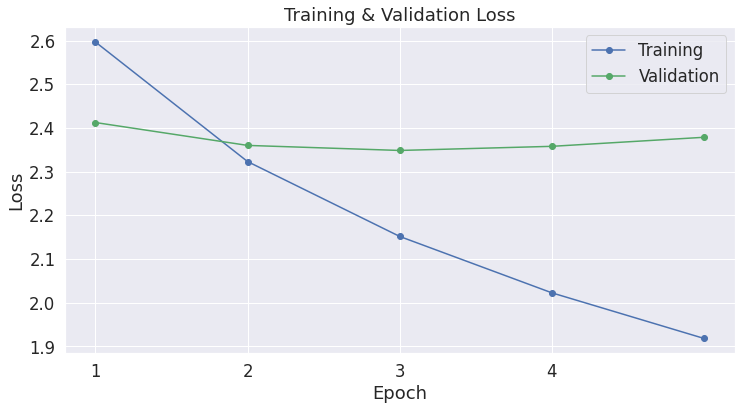

In [ ]:
import matplotlib.pyplot as plt

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()


In [ ]:

# 파라미터 표시
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (42005, 768)
transformer.wpe.weight                                   (2048, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [ ]:
# 모델 저장
# output_dir='/content/drive/MyDrive/KUBIG Project/KUBIG 2021-2 NLP/ind_model_save'
output_dir='/content/drive/MyDrive/KUBIG Project/KUBIG 2021-2 NLP/hip_model_save'

# 디렉토리 만들기
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# 모델, 토크나이저 등 저장
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer_gpt3.save_pretrained(output_dir)

Saving model to /content/drive/MyDrive/KUBIG Project/KUBIG 2021-2 NLP/hip_model_save


('/content/drive/MyDrive/KUBIG Project/KUBIG 2021-2 NLP/hip_model_save/tokenizer_config.json',
 '/content/drive/MyDrive/KUBIG Project/KUBIG 2021-2 NLP/hip_model_save/special_tokens_map.json',
 '/content/drive/MyDrive/KUBIG Project/KUBIG 2021-2 NLP/hip_model_save/vocab.txt',
 '/content/drive/MyDrive/KUBIG Project/KUBIG 2021-2 NLP/hip_model_save/added_tokens.json',
 '/content/drive/MyDrive/KUBIG Project/KUBIG 2021-2 NLP/hip_model_save/tokenizer.json')

In [ ]:
# !ls -l --block-size=K '/content/drive/MyDrive/KUBIG Project/KUBIG 2021-2 NLP/ind_model_save'
!ls -l --block-size=K '/content/drive/MyDrive/KUBIG Project/KUBIG 2021-2 NLP/hip_model_save'

total 514617K
-rw------- 1 root root      1K Aug 31 07:26 added_tokens.json
-rw------- 1 root root      1K Aug 31 07:26 config.json
-rw------- 1 root root 513622K Aug 31 07:26 pytorch_model.bin
-rw------- 1 root root      1K Aug 31 07:26 special_tokens_map.json
-rw------- 1 root root      1K Aug 31 07:26 tokenizer_config.json
-rw------- 1 root root    656K Aug 31 07:26 tokenizer.json
-rw------- 1 root root    337K Aug 31 07:26 vocab.txt


In [ ]:
# !ls -l --block-size=M '/content/drive/MyDrive/KUBIG Project/KUBIG 2021-2 NLP/ind_model_save/pytorch_model.bin'
!ls -l --block-size=M '/content/drive/MyDrive/KUBIG Project/KUBIG 2021-2 NLP/hip_model_save/pytorch_model.bin'

-rw------- 1 root root 502M Aug 31 07:26 '/content/drive/MyDrive/KUBIG Project/KUBIG 2021-2 NLP/hip_model_save/pytorch_model.bin'
